## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)



<a id='intro'></a>
### Introduction

For this project, we will run an A/B test run on the data of an e-commerce website.  Our goal is to help the company understand if they should implement the new landing page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[(df.landing_page == 'new_page') ^ (df.group == 'treatment')].shape[0]

3893

Check if any of the rows have missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 


In [8]:
df_newpage = df[(df.landing_page == 'new_page') & (df.group == 'treatment')]
df_oldpage = df[(df.landing_page == 'old_page') & (df.group == 'control')]
df2 = df_newpage.append(df_oldpage, ignore_index = True)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Count unique **user_id**s are in **df2**

In [10]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**

In [11]:
df_user_id_duplicate = df2.groupby(df2.user_id).size() > 1
df_user_id_duplicate[df_user_id_duplicate == True]

user_id
773192    True
dtype: bool

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2.drop_duplicates("user_id", inplace=True)

Calc the probability of an individual converting regardless of the page they receive

In [14]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control = df2.query("group == 'control'").shape[0]
control_n_convert = df2[(df2.group == 'control') & (df2.converted == 1)].shape[0]
act_pold = control_n_convert / control
act_pold

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment = df2.query("group == 'treatment'").shape[0]
treatment_n_convert = df2[(df2.group == 'treatment') & (df2.converted == 1)].shape[0]
act_pnew = treatment_n_convert / control
act_pnew

0.1188375070556328

Calc the probability that an individual received the new page

In [17]:
treatment / df2.shape[0]

0.5000619442226688

<a id='ab_test'></a>
### Part II - A/B Test

`1.`   If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% we can state our hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new} <= p_{old}$$

$$ H_1: p_{new} > p_{old}$$

$$\alpha = 0.05$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

We'll Use the cells below to provide the necessary parts of this simulation.<br><br>

1. calc the **convert rate** for $p_{new}$ under the null 

In [18]:
pnew = (treatment_n_convert +control_n_convert)/ (treatment+control)
pnew

0.11959708724499628

2. calc the **convert rate** for $p_{old}$ under the null <br><br>

In [19]:
pold = (treatment_n_convert +control_n_convert)/ (treatment+control)
pold

0.11959708724499628

3. calc $n_{new}$

In [20]:
nnew = treatment
nnew

145310

4. calc $n_{old}$

In [21]:
nold = control
nold

145274

5. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice(2, size=nnew, p=[1-pnew,pnew])
new_page_converted.view()

array([0, 0, 0, ..., 0, 0, 0])

6. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice(2, size=nold, p=[1-pold,pold])
old_page_converted.view()

array([0, 1, 0, ..., 1, 0, 0])

7. Find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [24]:
act_diff = new_page_converted.mean() - old_page_converted.mean()
act_diff

-0.0012618278827694063

8. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated in parts **1 - 7** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = []
for q in range(10000):
    new_page_converted = np.random.choice(2, size=nnew, p=[1-pnew,pnew])
    old_page_converted = np.random.choice(2, size=nold, p=[1-pold,pold])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

Plot a histogram of the **p_diffs**. It looks like a normal distribution.

(array([    6.,    70.,   394.,  1542.,  2772.,  2919.,  1721.,   495.,
           73.,     8.]),
 array([ -4.93002534e-03,  -3.95956191e-03,  -2.98909848e-03,
         -2.01863506e-03,  -1.04817163e-03,  -7.77082078e-05,
          8.92755218e-04,   1.86321864e-03,   2.83368207e-03,
          3.80414550e-03,   4.77460892e-03]),
 <a list of 10 Patch objects>)

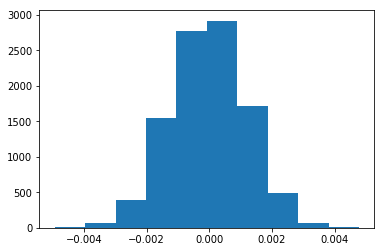

In [26]:
p_diffs = np.array(p_diffs) 
plt.hist(p_diffs)

calculate the p-value: The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [27]:
(p_diffs > (act_pnew - act_pold)).mean()

0.9002

In this case, since p-value is greater than the alpha, we did not reject the null. There is not significant evidence that the new page generates more traffic.